In [1]:
import os
import sys
sys.path.append(os.getcwd()+"/../..")
from src import paths

import pandas as pd
import numpy as np

import torch

from datasets import load_dataset, concatenate_datasets

from sklearn.metrics import f1_score, recall_score, precision_score, ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.metrics.pairwise import cosine_similarity

from src.utils import load_ms_data, ms_label2id

from typing import Callable

import warnings
warnings.filterwarnings('ignore')

# import seaborn as sns
import matplotlib.pyplot as plt

# Prompting Strategies 13B

In [2]:
target_names = ['ppms','rrms', 'spms', 'no_ms']
def load_results(filename:str, load_line:bool = False):
    results = torch.load(paths.RESULTS_PATH/"ms-diag"/filename, map_location=torch.device('cpu'))
    
    last_hidden_states = results.pop("last_hidden_states")
    last_hidden_states = last_hidden_states.cpu()
    
    results["preds"] = np.argmax(cosine_similarity(last_hidden_states, labels_encoded), axis=1)

    df = pd.DataFrame(results)

    if rids:
        df = df[df["rid"].isin(rids)]
    
    if "line" in filename and not load_line:
        return convert_line2report(df, filename)
    else:
        return df

def show_results(results:pd.DataFrame):
    contains_any = results["prediction"].str.contains('|'.join(base_labels[0]), case=False)
    print("Percent of correctly formatted labels: ", sum(contains_any)/len(results))
    print(classification_report(y_true = results["labels"], y_pred = results["preds"]))
    ConfusionMatrixDisplay.from_predictions(y_true = results["labels"], y_pred = results["preds"], display_labels=ms_label2id, xticks_rotation="vertical")

def convert_line2report(results: pd.DataFrame, filename: str):
    split = filename.split("_")[4]
    df = load_ms_data("line")
    
    if split == "all":
        df = concatenate_datasets([df["train"], df["val"], df["test"]])
    else:
        df = df[split]
    
    results['index_within_rid'] = df['index_within_rid']

    df_list = []

    for i, rid_data in results.groupby("rid"):
        _df = rid_data[rid_data["index_within_rid"] == 0].copy()  # Create a copy to avoid chained indexing warnings

        rid_data_sorted = rid_data.sort_values('index_within_rid')
        _df.loc[:, "report"] = "\n".join(rid_data_sorted["report"].tolist())

        # There should only be one kind label other than 3 (no MS) or just 3
        if rid_data["labels"].value_counts().index[0] == 3 and len(rid_data["labels"].value_counts()) > 1:
            _df.loc[:, "labels"] = rid_data["labels"].value_counts().index[1]
        else:
            _df.loc[:, "labels"] = rid_data["labels"].value_counts().index[0]

        _df.loc[:, "rid"] = i
        df_list.append(_df)

    df_agg = pd.concat(df_list, ignore_index=True)
    
    return df_agg

def summarize_performance(files: list[str]):
    dfs = []
    for file in files:
        splitted_filename = file.split("_")
        model_name = splitted_filename[1]
        level = splitted_filename[3]
        split = splitted_filename[4]
        strategy = " ".join(splitted_filename[5:])[:-3]

        results = load_results(file)

        metric_dict = classification_report(y_true=results["labels"], y_pred=results["preds"], output_dict=True,
                                            target_names=target_names)

        # Create a dictionary with flattened keys
        _df = pd.json_normalize(metric_dict)
        

        # Add additional information
        _df["strategy"] = strategy
        _df["level"] = level
        _df["split"] = split
        contains_any = results["prediction"].str.contains('|'.join(base_labels[0]), case=False)
        _df["valid_label"] = sum(contains_any)/len(results)

        # Reorder columns
        reordered_cols = _df.columns[-4:].append(_df.columns[:-4])
        _df = _df[reordered_cols]

        dfs.append(_df)

    return pd.concat(dfs)



In [3]:
pd.set_option('display.max_columns', 50)
base_labels = torch.load(paths.RESULTS_PATH/"ms-diag"/"label_encodings_Llama2-MedTuned-13b.pt")
base_labels[0], ms_label2id
# Reformat base labels such that dim 0 of tensor corresponds to ms_label2id index
labels_encoded = base_labels[1][[2,0,1,3],:].cpu()
summarize_performance(["ms-diag_Llama2-MedTuned-13b_4bit_all_all_zero_shot_vanilla.pt",
                      "ms-diag_Llama2-MedTuned-13b_4bit_all_all_zero_shot_instruction.pt",
                      "ms-diag_Llama2-MedTuned-13b_4bit_all_all_few_shot_vanilla.pt",
                      "ms-diag_Llama2-MedTuned-13b_4bit_all_all_few_shot_instruction.pt",
                       "ms-diag_Llama2-MedTuned-13b_4bit_line_all_zero_shot_vanilla.pt",
                      "ms-diag_Llama2-MedTuned-13b_4bit_line_all_zero_shot_instruction.pt",
                      "ms-diag_Llama2-MedTuned-13b_4bit_line_all_few_shot_vanilla.pt",
                      "ms-diag_Llama2-MedTuned-13b_4bit_line_all_few_shot_instruction.pt"
                      ])

,strategy,level,split,valid_label,accuracy,ppms.precision,ppms.recall,ppms.f1-score,ppms.support,rrms.precision,rrms.recall,rrms.f1-score,rrms.support,spms.precision,spms.recall,spms.f1-score,spms.support,no_ms.precision,no_ms.recall,no_ms.f1-score,no_ms.support,macro avg.precision,macro avg.recall,macro avg.f1-score,macro avg.support,weighted avg.precision,weighted avg.recall,weighted avg.f1-score,weighted avg.support
0,zero shot vanilla,all,all,0.088083,0.326425,0.020408,0.153846,0.036036,13.0,0.716981,0.290076,0.413043,131.0,0.260870,0.666667,0.375000,9.0,0.894737,0.425,0.576271,40.0,0.473249,0.383897,0.350088,193.0,0.685633,0.326425,0.419705,193.0
0,zero shot instruction,all,all,0.202073,0.782383,0.282051,0.846154,0.423077,13.0,0.962264,0.778626,0.860759,131.0,0.571429,0.444444,0.500000,9.0,0.829268,0.850,0.839506,40.0,0.661253,0.729806,0.655836,193.0,0.870657,0.782383,0.810050,193.0
0,few shot vanilla,all,all,0.145078,0.787565,0.333333,0.153846,0.210526,13.0,0.805195,0.946565,0.870175,131.0,0.428571,0.333333,0.375000,9.0,0.884615,0.575,0.696970,40.0,0.612929,0.502186,0.538168,193.0,0.772309,0.787565,0.766754,193.0
0,few shot instruction,all,all,0.186528,0.440415,0.187500,0.230769,0.206897,13.0,0.877193,0.381679,0.531915,131.0,0.095745,1.000000,0.174757,9.0,0.884615,0.575,0.696970,40.0,0.511263,0.546862,0.402635,193.0,0.795835,0.440415,0.527576,193.0
0,zero shot vanilla,line,all,0.129534,0.652850,0.130435,0.461538,0.203390,13.0,0.906250,0.664122,0.766520,131.0,0.400000,0.888889,0.551724,9.0,0.806452,0.625,0.704225,40.0,0.560784,0.659887,0.556465,193.0,0.809702,0.652850,0.705662,193.0
0,zero shot instruction,line,all,0.269430,0.860104,0.866667,1.000000,0.928571,13.0,0.990566,0.801527,0.886076,131.0,0.888889,0.888889,0.888889,9.0,0.634921,1.000,0.776699,40.0,0.845261,0.922604,0.870059,193.0,0.903770,0.860104,0.866401,193.0
0,few shot vanilla,line,all,0.274611,0.766839,0.440000,0.846154,0.578947,13.0,0.941176,0.854962,0.896000,131.0,0.391304,1.000000,0.562500,9.0,0.615385,0.400,0.484848,40.0,0.596966,0.775279,0.630574,193.0,0.814255,0.766839,0.773880,193.0
0,few shot instruction,line,all,0.274611,0.849741,0.666667,0.769231,0.714286,13.0,0.972973,0.824427,0.892562,131.0,0.562500,1.000000,0.720000,9.0,0.725490,0.925,0.813187,40.0,0.731907,0.879665,0.785009,193.0,0.881908,0.849741,0.856056,193.0


- Improvement from zero shot vanilla to few shot vanilla. This helps especially with valid_label output (so model knows better how to structure output)
- Improvement from vanilla to instruct (leveraging pretraining)
- Combining few shot with instruct has mixed results. Unclear how pretrain objective and few shot interact maybe model is confused because of mixed input format
- Zero-Shot Instruct seems to perform best. Is in line with their fine-tune objective
- Improvement from all of report to just line. Prompt gets less washed out. Model can focus on relevant input. Especially recall for actual ms classes is really good, indicating that when just presenting relevant info to the model it is quite adept at filtering out. Precision is often less because model has trouble with not enough info (no_ms) recall, it is prone to hallucinations. Because of imbalancedness, just a few falsely classified no_ms classes can have huge impact

## Zero-Shot

### Vanilla

Percent of correctly formatted labels:  0.08808290155440414
              precision    recall  f1-score   support

           0       0.02      0.15      0.04        13
           1       0.72      0.29      0.41       131
           2       0.26      0.67      0.38         9
           3       0.89      0.42      0.58        40

    accuracy                           0.33       193
   macro avg       0.47      0.38      0.35       193
weighted avg       0.69      0.33      0.42       193



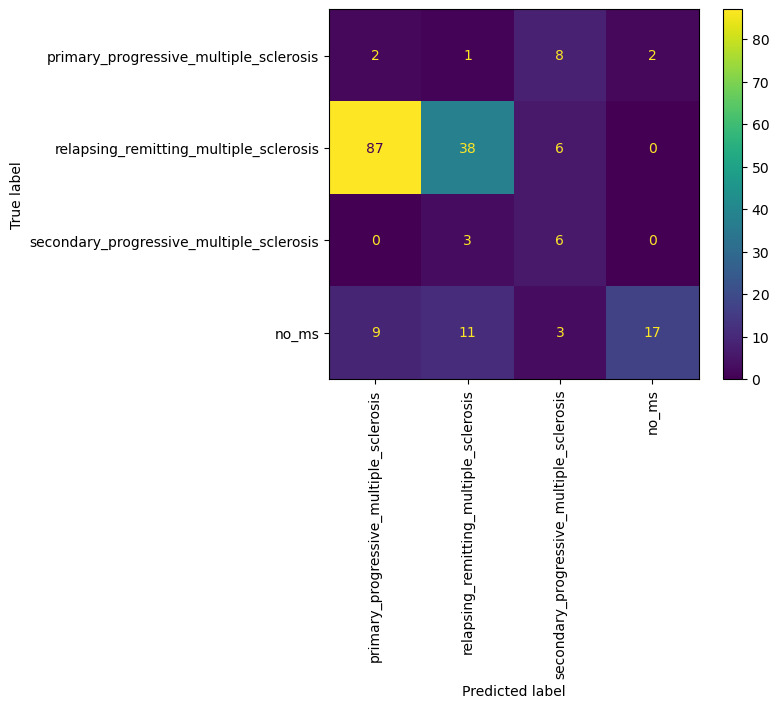

In [4]:
# Whole report
results = load_results("ms-diag_Llama2-MedTuned-13b_4bit_all_all_zero_shot_vanilla.pt")
show_results(results)

Percent of correctly formatted labels:  0.12953367875647667
              precision    recall  f1-score   support

           0       0.13      0.46      0.20        13
           1       0.91      0.66      0.77       131
           2       0.40      0.89      0.55         9
           3       0.81      0.62      0.70        40

    accuracy                           0.65       193
   macro avg       0.56      0.66      0.56       193
weighted avg       0.81      0.65      0.71       193



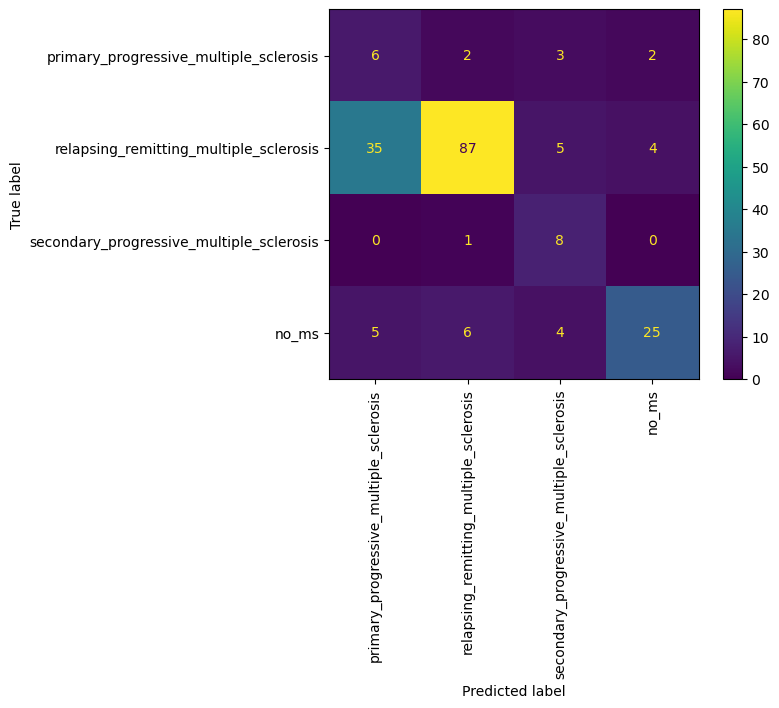

In [5]:
# Line report
results = load_results("ms-diag_Llama2-MedTuned-13b_4bit_line_all_zero_shot_vanilla.pt")
show_results(results)

### Instruction

Percent of correctly formatted labels:  0.20207253886010362
              precision    recall  f1-score   support

           0       0.28      0.85      0.42        13
           1       0.96      0.78      0.86       131
           2       0.57      0.44      0.50         9
           3       0.83      0.85      0.84        40

    accuracy                           0.78       193
   macro avg       0.66      0.73      0.66       193
weighted avg       0.87      0.78      0.81       193



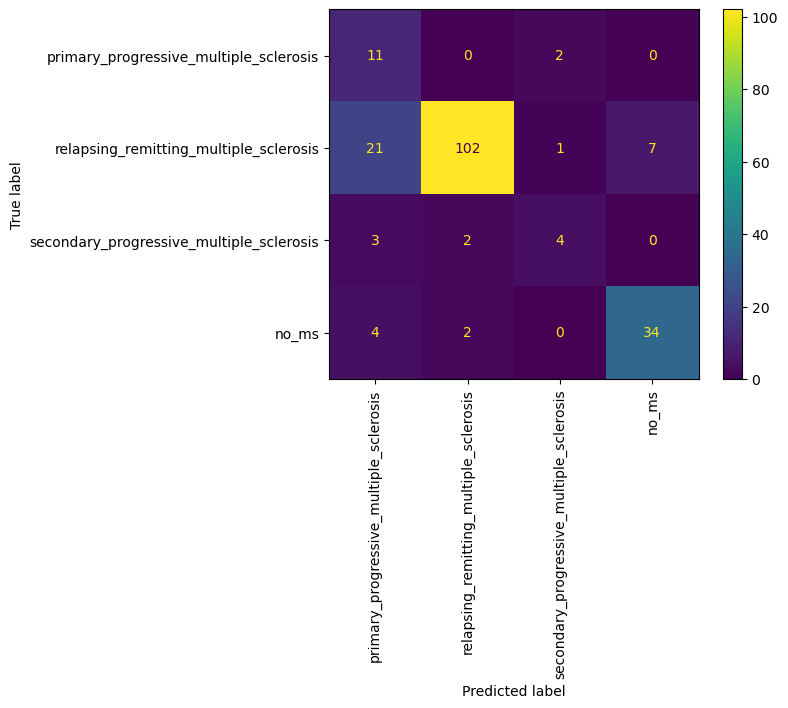

In [6]:
# Whole Report
results = load_results("ms-diag_Llama2-MedTuned-13b_4bit_all_all_zero_shot_instruction.pt")
show_results(results)

Percent of correctly formatted labels:  0.2694300518134715
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       0.99      0.80      0.89       131
           2       0.89      0.89      0.89         9
           3       0.63      1.00      0.78        40

    accuracy                           0.86       193
   macro avg       0.85      0.92      0.87       193
weighted avg       0.90      0.86      0.87       193



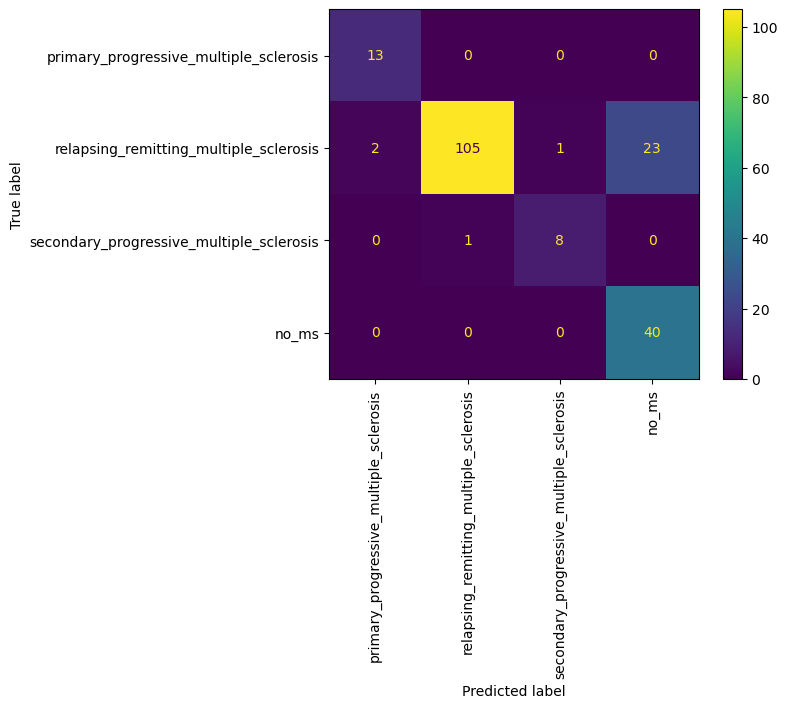

In [7]:
# Line Result
results = load_results("ms-diag_Llama2-MedTuned-13b_4bit_line_all_zero_shot_instruction.pt")
show_results(results)

## Few-Shot

### Vanilla

Percent of correctly formatted labels:  0.14507772020725387
              precision    recall  f1-score   support

           0       0.33      0.15      0.21        13
           1       0.81      0.95      0.87       131
           2       0.43      0.33      0.38         9
           3       0.88      0.57      0.70        40

    accuracy                           0.79       193
   macro avg       0.61      0.50      0.54       193
weighted avg       0.77      0.79      0.77       193



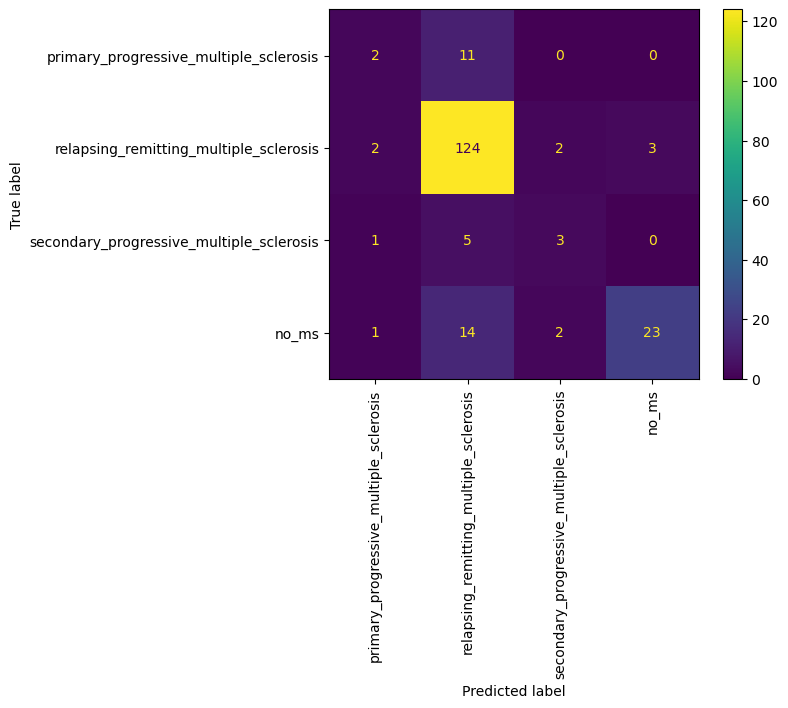

In [8]:
results = load_results("ms-diag_Llama2-MedTuned-13b_4bit_all_all_few_shot_vanilla.pt")
show_results(results)

Percent of correctly formatted labels:  0.27461139896373055
              precision    recall  f1-score   support

           0       0.44      0.85      0.58        13
           1       0.94      0.85      0.90       131
           2       0.39      1.00      0.56         9
           3       0.62      0.40      0.48        40

    accuracy                           0.77       193
   macro avg       0.60      0.78      0.63       193
weighted avg       0.81      0.77      0.77       193



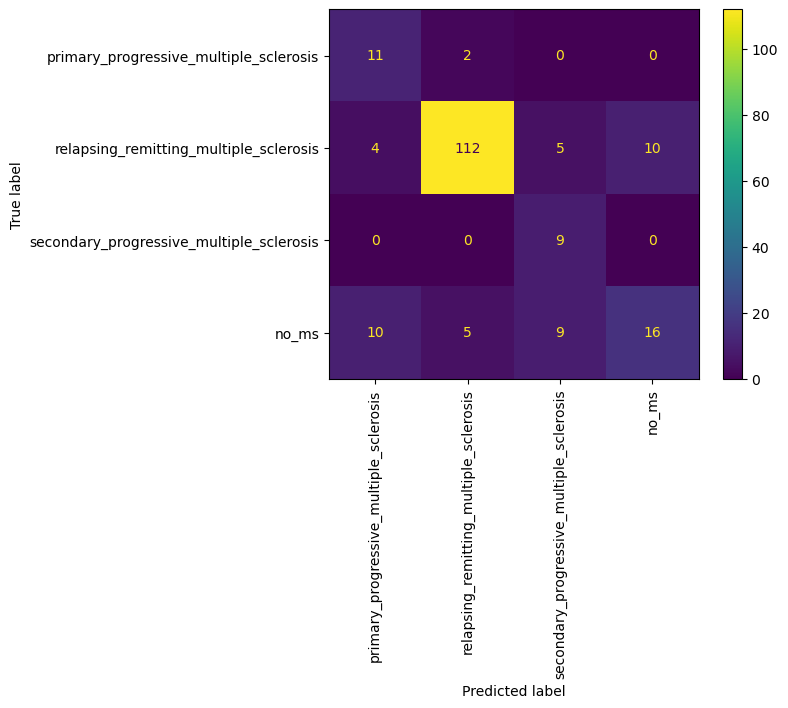

In [9]:
results = load_results("ms-diag_Llama2-MedTuned-13b_4bit_line_all_few_shot_vanilla.pt")
show_results(results)

### Instruction

Percent of correctly formatted labels:  0.18652849740932642
              precision    recall  f1-score   support

           0       0.19      0.23      0.21        13
           1       0.88      0.38      0.53       131
           2       0.10      1.00      0.17         9
           3       0.88      0.57      0.70        40

    accuracy                           0.44       193
   macro avg       0.51      0.55      0.40       193
weighted avg       0.80      0.44      0.53       193



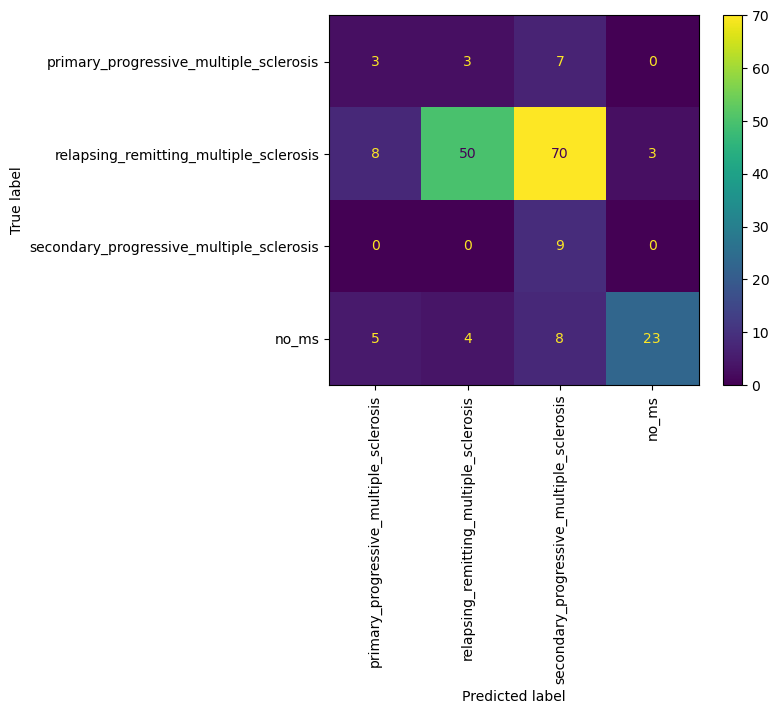

In [10]:
results = load_results("ms-diag_Llama2-MedTuned-13b_4bit_all_all_few_shot_instruction.pt")
show_results(results)

Percent of correctly formatted labels:  0.27461139896373055
              precision    recall  f1-score   support

           0       0.67      0.77      0.71        13
           1       0.97      0.82      0.89       131
           2       0.56      1.00      0.72         9
           3       0.73      0.93      0.81        40

    accuracy                           0.85       193
   macro avg       0.73      0.88      0.79       193
weighted avg       0.88      0.85      0.86       193



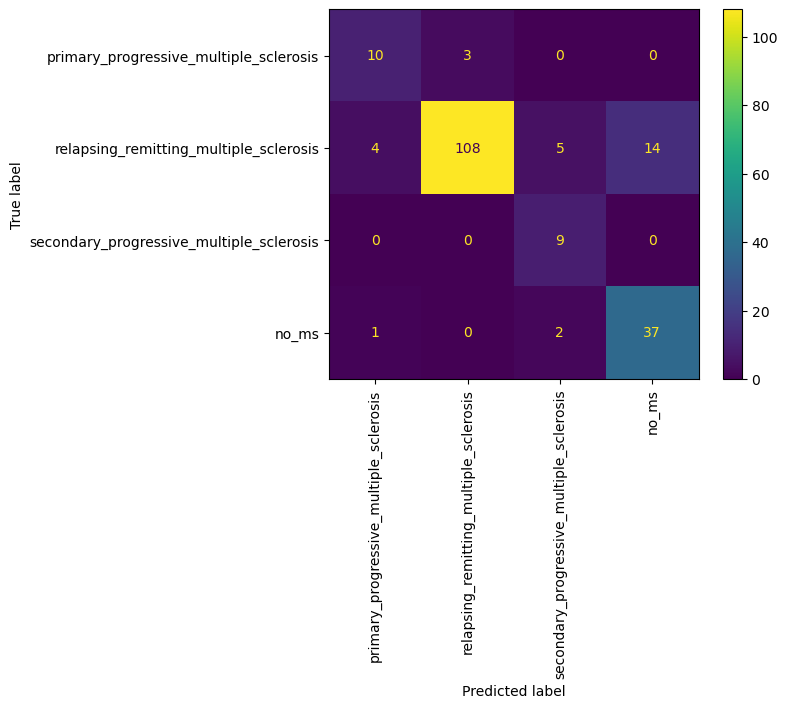

In [11]:
results = load_results("ms-diag_Llama2-MedTuned-13b_4bit_line_all_few_shot_instruction.pt")
show_results(results)

## Multi-Turn

Percent of correctly formatted labels:  0.05172413793103448
              precision    recall  f1-score   support

           0       0.10      0.75      0.18         4
           1       0.67      0.15      0.25        39
           2       0.00      0.00      0.00         3
           3       0.50      0.67      0.57        12

    accuracy                           0.29        58
   macro avg       0.32      0.39      0.25        58
weighted avg       0.56      0.29      0.30        58



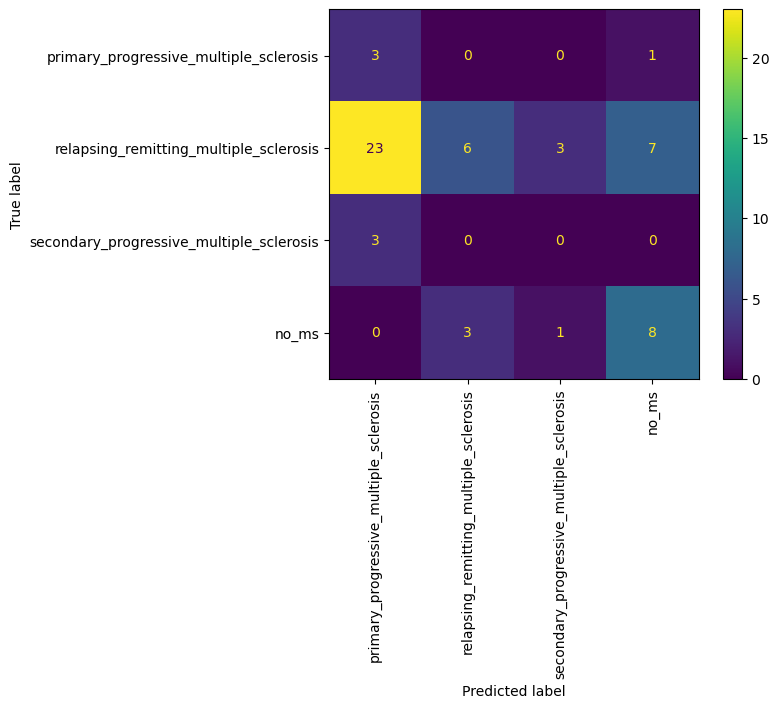

In [12]:
results = load_results("ms-diag_Llama2-MedTuned-13b_4bit_all_test_two_steps.pt")
show_results(results)

Percent of correctly formatted labels:  0.8240112994350283
              precision    recall  f1-score   support

           0       0.06      1.00      0.11        13
           1       0.37      0.83      0.51       131
           2       0.19      0.89      0.31         9
           3       0.99      0.87      0.93      3387

    accuracy                           0.87      3540
   macro avg       0.40      0.90      0.46      3540
weighted avg       0.97      0.87      0.91      3540



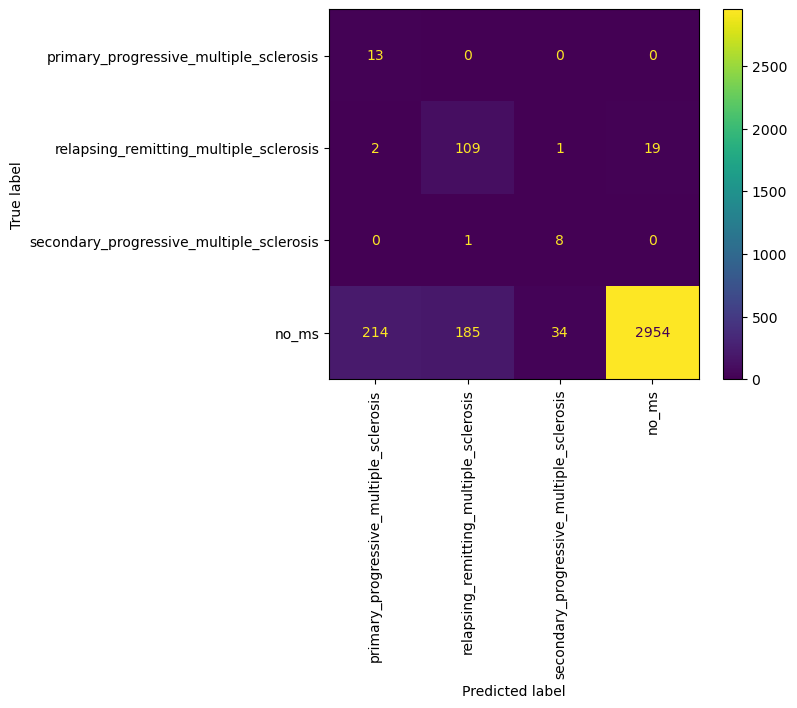

In [13]:
results = load_results("ms-diag_Llama2-MedTuned-13b_4bit_line_all_zero_shot_instruction.pt", load_line = True)
show_results(results)

# Prompting Strategies 7B

# Summary

In [14]:
base_labels = torch.load(paths.RESULTS_PATH/"ms-diag"/"label_encodings_Llama2-MedTuned-7b.pt")
base_labels[0], ms_label2id
# Reformat base labels such that dim 0 of tensor corresponds to ms_label2id index
labels_encoded = base_labels[1][[2,0,1,3],:].cpu()
summarize_performance(["ms-diag_Llama2-MedTuned-7b_4bit_all_all_zero_shot_vanilla.pt",
                      "ms-diag_Llama2-MedTuned-7b_4bit_all_all_zero_shot_instruction.pt",
                      "ms-diag_Llama2-MedTuned-7b_4bit_all_all_few_shot_vanilla.pt",
                      "ms-diag_Llama2-MedTuned-7b_4bit_all_all_few_shot_instruction.pt",
                       "ms-diag_Llama2-MedTuned-7b_4bit_line_all_zero_shot_vanilla.pt",
                      "ms-diag_Llama2-MedTuned-7b_4bit_line_all_zero_shot_instruction.pt",
                      "ms-diag_Llama2-MedTuned-7b_4bit_line_all_few_shot_vanilla.pt",
                      "ms-diag_Llama2-MedTuned-7b_4bit_line_all_few_shot_instruction.pt"
                      ])

,strategy,level,split,valid_label,accuracy,ppms.precision,ppms.recall,ppms.f1-score,ppms.support,rrms.precision,rrms.recall,rrms.f1-score,rrms.support,spms.precision,spms.recall,spms.f1-score,spms.support,no_ms.precision,no_ms.recall,no_ms.f1-score,no_ms.support,macro avg.precision,macro avg.recall,macro avg.f1-score,macro avg.support,weighted avg.precision,weighted avg.recall,weighted avg.f1-score,weighted avg.support
0,zero shot vanilla,all,all,0.000000,0.062176,0.125000,0.153846,0.137931,13.0,1.0,0.007634,0.015152,131.0,0.051724,1.000000,0.098361,9.0,0.000000,0.000,0.000000,40.0,0.294181,0.290370,0.062861,193.0,0.689588,0.062176,0.024162,193.0
0,zero shot instruction,all,all,0.227979,0.300518,0.104478,0.538462,0.175000,13.0,0.8,0.213740,0.337349,131.0,0.000000,0.000000,0.000000,9.0,0.323944,0.575,0.414414,40.0,0.307105,0.331800,0.231691,193.0,0.617181,0.300518,0.326655,193.0
0,few shot vanilla,all,all,0.191710,0.227979,0.200000,0.076923,0.111111,13.0,1.0,0.091603,0.167832,131.0,0.040323,0.555556,0.075188,9.0,0.500000,0.650,0.565217,40.0,0.435081,0.343520,0.229837,193.0,0.797735,0.227979,0.242051,193.0
0,few shot instruction,all,all,0.761658,0.222798,1.000000,0.076923,0.142857,13.0,0.0,0.000000,0.000000,131.0,0.046512,0.222222,0.076923,9.0,0.268456,1.000,0.423280,40.0,0.328742,0.324786,0.160765,193.0,0.125165,0.222798,0.100936,193.0
0,zero shot vanilla,line,all,0.000000,0.046632,1.000000,0.076923,0.142857,13.0,0.5,0.007634,0.015038,131.0,0.037234,0.777778,0.071066,9.0,0.000000,0.000,0.000000,40.0,0.384309,0.215584,0.057240,193.0,0.408472,0.046632,0.023143,193.0
0,zero shot instruction,line,all,0.238342,0.264249,0.714286,0.384615,0.500000,13.0,0.5,0.022901,0.043796,131.0,0.050847,0.666667,0.094488,9.0,0.596774,0.925,0.725490,40.0,0.465477,0.499796,0.340944,193.0,0.513546,0.264249,0.218172,193.0
0,few shot vanilla,line,all,0.336788,0.259067,0.333333,0.076923,0.125000,13.0,0.0,0.000000,0.000000,131.0,0.072000,1.000000,0.134328,9.0,0.615385,1.000,0.761905,40.0,0.255179,0.519231,0.255308,193.0,0.153351,0.259067,0.172591,193.0
0,few shot instruction,line,all,0.341969,0.269430,1.000000,0.307692,0.470588,13.0,0.0,0.000000,0.000000,131.0,0.066667,0.888889,0.124031,9.0,0.579710,1.000,0.733945,40.0,0.411594,0.549145,0.332141,193.0,0.190614,0.269430,0.189594,193.0


- Improvement from zero shot vanilla to few shot vanilla to . This helps especially with valid_label output (so model knows better how to structure output)
- Improvement from vanilla to instruct (leveraging pretraining)
- Few Shot Vanilla and Zero Shot instruct sometimes seem to perform equally well.
- Combining few shot with instruct has mixed results. Unclear how pretrain objective and few shot interact maybe model is confused because of mixed input format
- Improvement from all of report to just line. Prompt gets less washed out. Model can focus on relevant input. Especially recall for actual ms classes is really good, indicating that when just presenting relevant info to the model it is quite adept at filtering out. Precision is often less because model has trouble with not enough info (no_ms) recall, it is prone to hallucinations. Because of imbalancedness, just a few falsely classified no_ms classes can have huge impact

## Zero-Shot

### Vanilla

Percent of correctly formatted labels:  0.0
              precision    recall  f1-score   support

           0       0.12      0.15      0.14        13
           1       1.00      0.01      0.02       131
           2       0.05      1.00      0.10         9
           3       0.00      0.00      0.00        40

    accuracy                           0.06       193
   macro avg       0.29      0.29      0.06       193
weighted avg       0.69      0.06      0.02       193



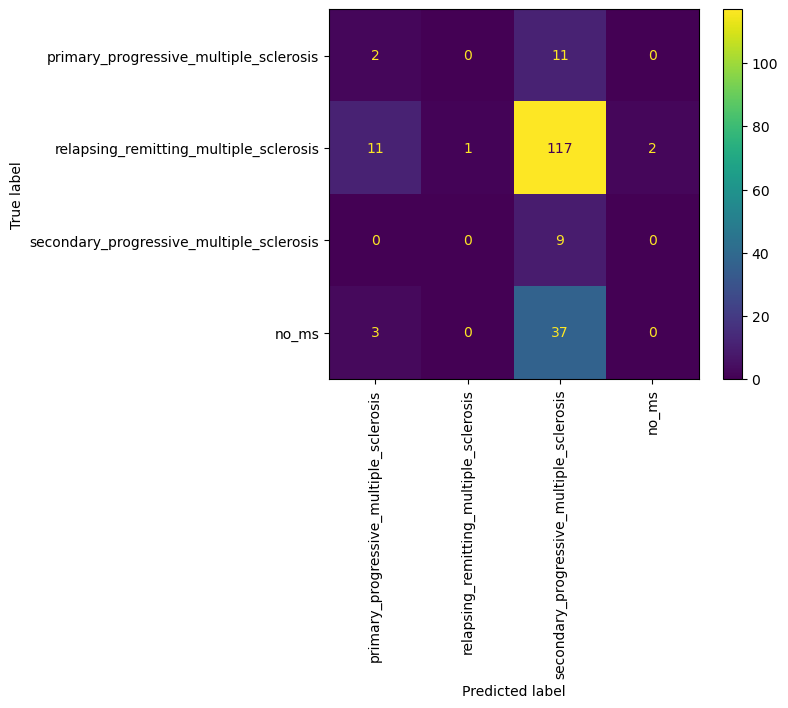

In [15]:
# Whole report
results = load_results("ms-diag_Llama2-MedTuned-7b_4bit_all_all_zero_shot_vanilla.pt")
show_results(results)

Percent of correctly formatted labels:  0.0
              precision    recall  f1-score   support

           0       1.00      0.08      0.14        13
           1       0.50      0.01      0.02       131
           2       0.04      0.78      0.07         9
           3       0.00      0.00      0.00        40

    accuracy                           0.05       193
   macro avg       0.38      0.22      0.06       193
weighted avg       0.41      0.05      0.02       193



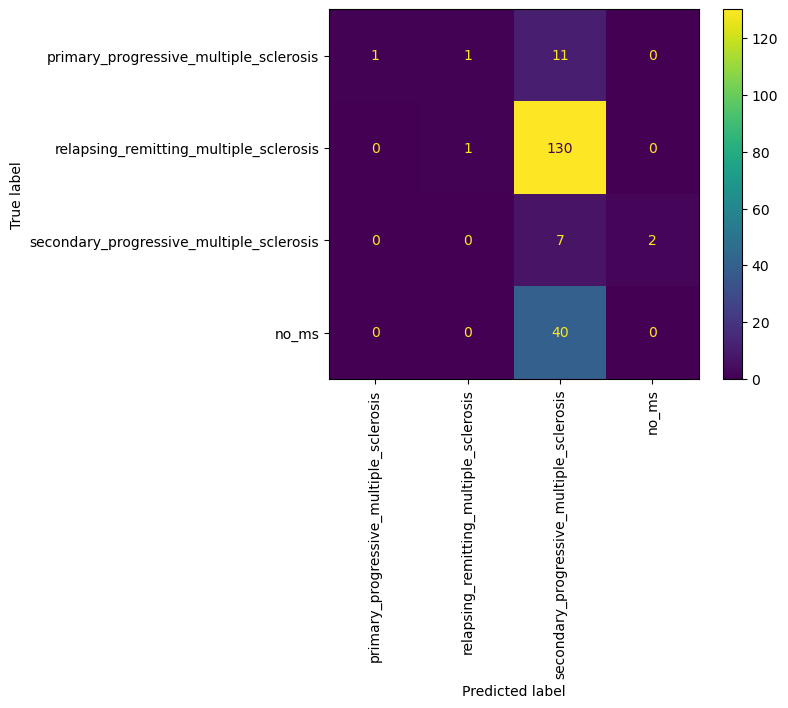

In [16]:
# Line report
results = load_results("ms-diag_Llama2-MedTuned-7b_4bit_line_all_zero_shot_vanilla.pt")
show_results(results)

### Instruction

Percent of correctly formatted labels:  0.22797927461139897
              precision    recall  f1-score   support

           0       0.10      0.54      0.18        13
           1       0.80      0.21      0.34       131
           2       0.00      0.00      0.00         9
           3       0.32      0.57      0.41        40

    accuracy                           0.30       193
   macro avg       0.31      0.33      0.23       193
weighted avg       0.62      0.30      0.33       193



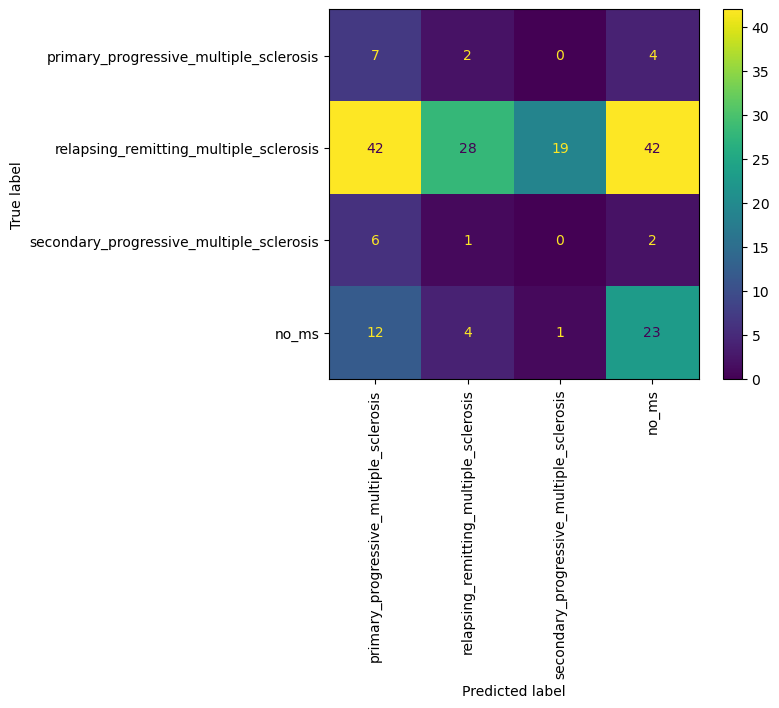

In [17]:
results = load_results("ms-diag_Llama2-MedTuned-7b_4bit_all_all_zero_shot_instruction.pt")
show_results(results)

Percent of correctly formatted labels:  0.23834196891191708
              precision    recall  f1-score   support

           0       0.71      0.38      0.50        13
           1       0.50      0.02      0.04       131
           2       0.05      0.67      0.09         9
           3       0.60      0.93      0.73        40

    accuracy                           0.26       193
   macro avg       0.47      0.50      0.34       193
weighted avg       0.51      0.26      0.22       193



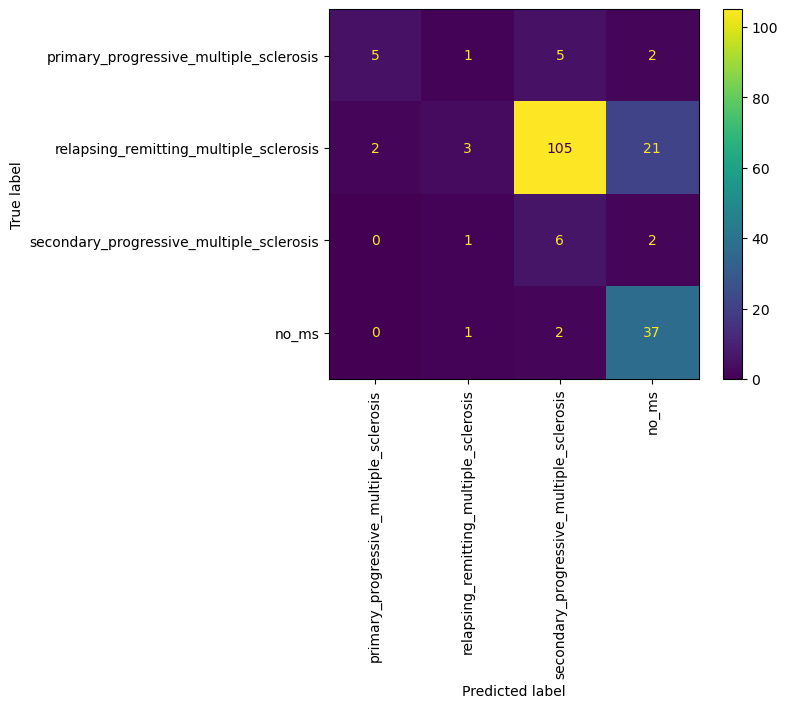

In [18]:
# Line Result
results = load_results("ms-diag_Llama2-MedTuned-7b_4bit_line_all_zero_shot_instruction.pt")
show_results(results)

## Few-Shot

### Vanilla

Percent of correctly formatted labels:  0.19170984455958548
              precision    recall  f1-score   support

           0       0.20      0.08      0.11        13
           1       1.00      0.09      0.17       131
           2       0.04      0.56      0.08         9
           3       0.50      0.65      0.57        40

    accuracy                           0.23       193
   macro avg       0.44      0.34      0.23       193
weighted avg       0.80      0.23      0.24       193



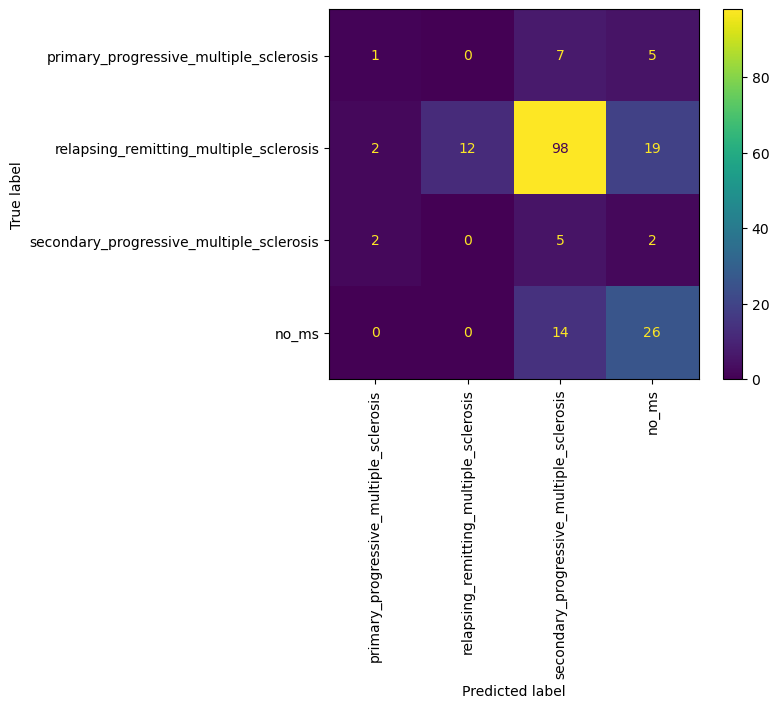

In [19]:
results = load_results("ms-diag_Llama2-MedTuned-7b_4bit_all_all_few_shot_vanilla.pt")
show_results(results)

Percent of correctly formatted labels:  0.33678756476683935
              precision    recall  f1-score   support

           0       0.33      0.08      0.12        13
           1       0.00      0.00      0.00       131
           2       0.07      1.00      0.13         9
           3       0.62      1.00      0.76        40

    accuracy                           0.26       193
   macro avg       0.26      0.52      0.26       193
weighted avg       0.15      0.26      0.17       193



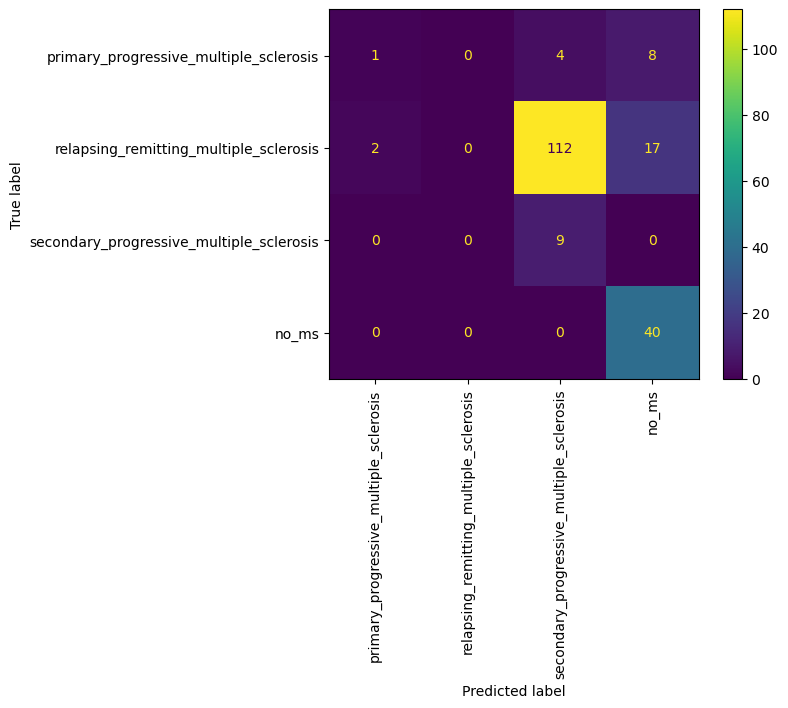

In [20]:
results = load_results("ms-diag_Llama2-MedTuned-7b_4bit_line_all_few_shot_vanilla.pt")
show_results(results)

### Instruction

Percent of correctly formatted labels:  0.7616580310880829
              precision    recall  f1-score   support

           0       1.00      0.08      0.14        13
           1       0.00      0.00      0.00       131
           2       0.05      0.22      0.08         9
           3       0.27      1.00      0.42        40

    accuracy                           0.22       193
   macro avg       0.33      0.32      0.16       193
weighted avg       0.13      0.22      0.10       193



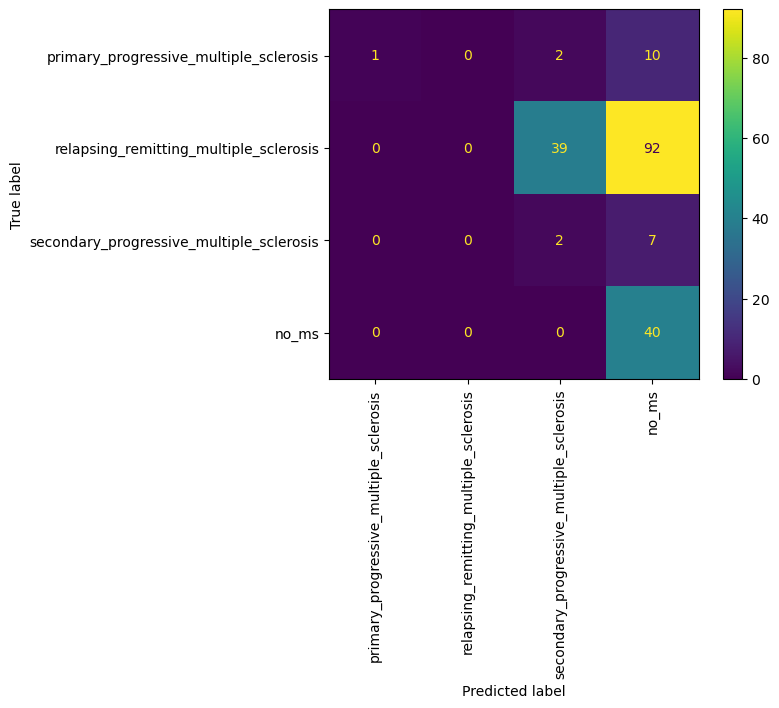

In [21]:
results = load_results("ms-diag_Llama2-MedTuned-7b_4bit_all_all_few_shot_instruction.pt")
show_results(results)

Percent of correctly formatted labels:  0.34196891191709844
              precision    recall  f1-score   support

           0       1.00      0.31      0.47        13
           1       0.00      0.00      0.00       131
           2       0.07      0.89      0.12         9
           3       0.58      1.00      0.73        40

    accuracy                           0.27       193
   macro avg       0.41      0.55      0.33       193
weighted avg       0.19      0.27      0.19       193



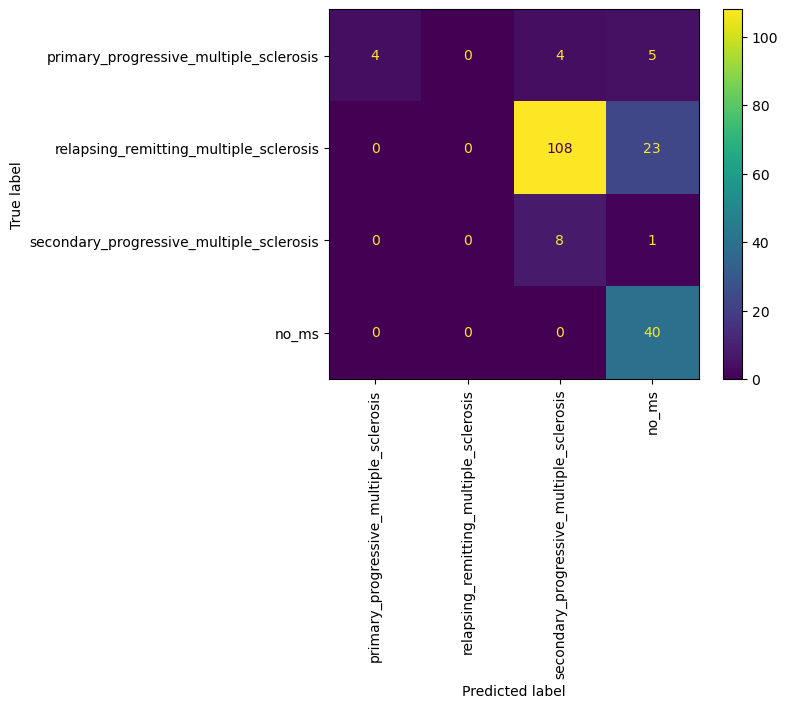

In [22]:
results = load_results("ms-diag_Llama2-MedTuned-7b_4bit_line_all_few_shot_instruction.pt")
show_results(results)

## Multi-Turn

Percent of correctly formatted labels:  0.015544041450777202
              precision    recall  f1-score   support

           0       0.33      0.08      0.12        13
           1       1.00      0.15      0.25       131
           2       0.04      0.44      0.08         9
           3       0.27      0.53      0.35        40

    accuracy                           0.23       193
   macro avg       0.41      0.30      0.20       193
weighted avg       0.76      0.23      0.26       193



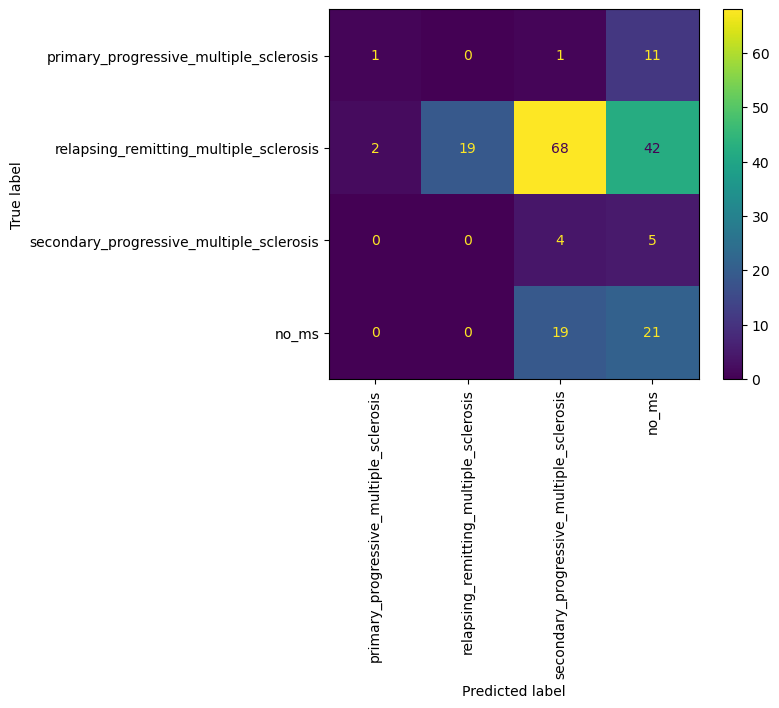

In [23]:
results = load_results("ms-diag_Llama2-MedTuned-7b_4bit_all_all_two_steps.pt")
show_results(results)

# Generation Strategies

In [24]:
job_id = 3592235
output = pd.read_csv(paths.RESULTS_PATH/'ms-diag/ms_diag-llama2-chat_zero-shot_generation-strats_3595180.csv')
# Map from output to label
# Dictionary to map keywords to labels
keyword_label_mapping = {
    "rrms": 'relapsing_remitting_multiple_sclerosis',
    "spms": 'secondary_progressive_multiple_sclerosis',
    "ppms": 'primary_progressive_multiple_sclerosis',
    "remittierend": 'relapsing_remitting_multiple_sclerosis',
    "schubförmig": 'relapsing_remitting_multiple_sclerosis',
    "sekundär": 'secondary_progressive_multiple_sclerosis',
    "primär": 'primary_progressive_multiple_sclerosis',
}

# Number of columns in the results dataframe
n_cols = len(output.columns)

# Function to assign labels based on text content
def assign_label(text):
    for keyword, label in keyword_label_mapping.items():
        if keyword in text.lower():
            return label
    return "unknown"  # Default label if no keyword is found

# Assign labels to each text in the list
for col in output.columns[1:]:
    output[f'{col}_r'] = output[col].apply(assign_label)

In [25]:
# Count "unknown" labels per column
for col in output.columns[n_cols:]:
    print(f'{col}: {output[col].value_counts()["unknown"]}')

truncate_300_strategy_greedy_r: 2
truncate_300_strategy_contrastive_r: 8
truncate_300_strategy_sampling_r: 4
truncate_300_strategy_beam_r: 1
truncate_600_strategy_greedy_r: 5
truncate_600_strategy_contrastive_r: 11
truncate_600_strategy_sampling_r: 6
truncate_600_strategy_beam_r: 2
truncate_1200_strategy_greedy_r: 11
truncate_1200_strategy_contrastive_r: 21
truncate_1200_strategy_sampling_r: 13
truncate_1200_strategy_beam_r: 3


In [26]:
def calculate_metrics(cm:np.ndarray):
    """Calculate metrics from a confusion matrix. Even if matrix is not square, it will calculate metrics for each class."""
    num_classes = len(cm)

    precision = []
    recall = []
    f1_score = []

    for i in range(num_classes):
        # True Positive, False Positive, False Negative
        TP = cm[i, i]
        FP = np.sum(cm[:, i]) - TP
        FN = np.sum(cm[i, :]) - TP

        # Precision, Recall, F1 Score
        precision_i = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall_i = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score_i = 2 * precision_i * recall_i / (precision_i + recall_i) if (precision_i + recall_i) > 0 else 0

        precision.append(precision_i)
        recall.append(recall_i)
        f1_score.append(f1_score_i)

    weighted_precision = np.sum(np.array(precision) * np.sum(cm, axis=1)) / np.sum(cm)
    weighted_recall = np.sum(np.array(recall) * np.sum(cm, axis=1)) / np.sum(cm)
    weighted_f1_score = np.sum(np.array(f1_score) * np.sum(cm, axis=1)) / np.sum(cm)

    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1_score = np.mean(f1_score)

    micro_precision = np.sum(cm.diagonal()) / np.sum(cm)
    micro_recall = np.sum(cm.diagonal()) / np.sum(cm)
    micro_f1_score = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0

    return {
        'weighted_precision': weighted_precision,
        'weighted_recall': weighted_recall,
        'weighted_f1_score': weighted_f1_score,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1_score': macro_f1_score,
        'micro_precision': micro_precision,
        'micro_recall': micro_recall,
        'micro_f1_score': micro_f1_score
    }


In [27]:
# Confusion matrix
labels = list(set(output["labels"])) + ["unknown"]
results = []
for col in output.columns[n_cols:]:
    print(f'{col}:')
    conf_mat = confusion_matrix(y_true=output['labels'], y_pred=output[col], labels=labels)
    sns.heatmap(conf_mat, annot=True)
    results.append(calculate_metrics(conf_mat))
    print()
    break

pd.DataFrame(results, index=output.columns[n_cols:])

truncate_300_strategy_greedy_r:


NameError: name 'sns' is not defined

In [ ]:
labels = ['primary_progressive_multiple_sclerosis', 'relapsing_remitting_multiple_sclerosis', 'secondary_progressive_multiple_sclerosis', 'unknown']
label_names = ['PPMS', 'RRMS', 'SPMS', 'unknown']
results = []

# Set the number of columns in the grid
grid_cols = 2
grid_rows = 6

# Create subplots
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(20, 10))

for idx, col in enumerate(output.columns[n_cols:]):
    row_idx = idx // grid_cols
    col_idx = idx % grid_cols

    # Calculate confusion matrix
    conf_mat = confusion_matrix(y_true=output['labels'], y_pred=output[col], labels=labels)

    # Plot heatmap in the corresponding subplot
    sns.heatmap(conf_mat[:-1,:], ax=axes[row_idx, col_idx], annot=True, fmt='d', cmap='Blues')
    axes[row_idx, col_idx].set_title(col)
    axes[row_idx, col_idx].set(yticklabels=[])
    axes[row_idx, col_idx].set(xticklabels=[])
    axes[row_idx, col_idx].tick_params(left=False, bottom=False)

    if col_idx == 0:
        axes[row_idx, col_idx].set(yticklabels=label_names[:-1])
        plt.setp(axes[row_idx, col_idx].get_yticklabels(), rotation=0, horizontalalignment='right')
        axes[row_idx, col_idx].collections[0].colorbar.remove()
    
    if row_idx == grid_rows - 1:
        axes[row_idx, col_idx].set(xticklabels=label_names)

    
    # Calculate metrics and append to the results
    results.append(calculate_metrics(conf_mat))

# Adjust layout
plt.tight_layout()

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Predicted Class", labelpad=20, fontsize=16)
plt.ylabel("True Class", labelpad=20, fontsize=16)

# Display the grid of heatmaps
plt.show()

# Display the results in a DataFrame
results_df = pd.DataFrame(results, index=output.columns[n_cols:]).round(2)
display(results_df)


In [ ]:
# Latex Table
num_strategies = 4
latex_string_first_row = r"\multirow{{4}}{{*}}{{{truncation_size}}} & {{{strategy}}} & {{{precision}}} & {{{recall}}} & {{{f1}}} \\"
latex_string_other_rows = r" & {{{strategy}}} & {{{precision}}} & {{{recall}}} & {{{f1}}} \\"

for idx, index in enumerate(results_df.index):
    truncation_size = index.split('_')[1]
    strategy = index.split('_')[3].capitalize()
    if idx %num_strategies == 0:
        print(r"\midrule")
        print(latex_string_first_row.format(truncation_size=truncation_size, strategy=strategy, precision=results_df.iloc[idx, 0], recall=results_df.iloc[idx, 1], f1=results_df.iloc[idx, 2]))
    else:
        print(latex_string_other_rows.format(strategy=strategy, precision=results_df.iloc[idx, 0], recall=results_df.iloc[idx, 1], f1=results_df.iloc[idx, 2]))